<a href="https://colab.research.google.com/github/yisiszhang/AdvancedPython/blob/main/Precept1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precept 1
In this project, we will use a dataset with multiple predictors to predict a response.

You tasks are

1. Split data into training and test sets.
2. Perform multiple linear regression using the full predictors and estimate the prediction accuracy using the test set.
3. Perform variable selection using the training set and compare the prediction accuracy with the full model using the test set.

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 49.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [7]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
from sklearn.datasets import make_regression
# generate regression dataset
# Try different noise. You should see the benefit of variable selection for noisy data
X, y = make_regression(n_samples=1000, n_features=20, n_informative=10, noise=100.0, random_state=1)
n,d = X.shape

In [46]:
# Split the data
from sklearn.model_selection import train_test_split
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio)

print(X_train.shape)
print(X_test.shape)

(800, 20)
(200, 20)


In [47]:
# Fit multiple linear regression using the full predictors
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

print(linreg.coef_)
# Print estimated coefficients.

[ 71.61748413   0.56170322  -6.46657192   3.76585984  25.88617603
  78.49998786  39.60822268  26.94624779  -7.18796607  -2.15960209
  -3.61753612   8.1842629    5.86232879  -0.84442382 -11.02349929
  46.15896016  67.22912326  -4.14362167   2.24820706  42.24392801]


In [48]:
# Estimate accuracy. You can report MSE and R2
from sklearn import metrics
y_pred = linreg.predict(X_test)

# Print MSE and R2
print(metrics.mean_squared_error(y_test, y_pred))
print(metrics.r2_score(y_test, y_pred))

11729.019271582163
0.646840025099076


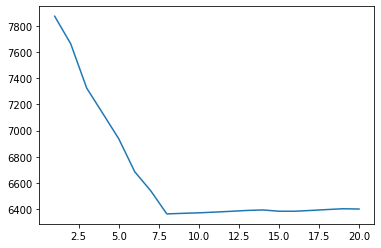

(array([ 0,  4,  5,  6,  7, 15, 16, 19]),)

In [31]:
# Perform variable selection using 1. Kbest/forward
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def aic(rss,n,d):
  return 2*d + n*np.log(rss/n)

def bic(rss,n,d):
  return d*np.log(n) + n*np.log(rss/n)

def adjustR2(rss,tss,n,d):
  return 1-rss/(n-d-1)/tss*(n-1)

# For each number of features (1 - d-1) specified apply the forward selection 
# And calculate the criteria
cri = np.zeros(d)  
for i in range(d-1):
  regr_sel = linear_model.LinearRegression()
  #sfs = SequentialFeatureSelector(regr_sel, n_features_to_select=i+1,direction='forward')
  sfs = SelectKBest(score_func=f_regression, k=i+1)
  sfs.fit(X_train,y_train)
  X_sel = sfs.transform(X_train)
  n,dsel = X_sel.shape
  regr_sel.fit(X_sel, y_train)
  y_hat = regr_sel.predict(X_sel)
  rss = ((y_train - y_hat)**2).sum()
  cri[i] = bic(rss, n, dsel)

# rss of full model
y_hat = linreg.predict(X_train)
rss = ((y_train - y_hat)**2).sum()
cri[d-1] = bic(rss, n, d)

# plot the criteria over d selected
plt.plot(np.arange(d)+1, cri)
plt.show()

# Print indices of selected variables
best_d = np.argmin(cri) + 1
#sfs = SequentialFeatureSelector(linreg, n_features_to_select=best_d)
sfs = SelectKBest(score_func=f_regression, k=best_d)
sfs.fit(X_train,y_train)
np.where(sfs.get_support())

In [49]:
# Estimate prediction accuracy using the test data
X_sel_train = sfs.transform(X_train)
regr_sel = linear_model.LinearRegression()
regr_sel.fit(X_sel_train, y_train)

X_sel_test = sfs.transform(X_test)
y_pred = regr_sel.predict(X_sel_test)

# Print the MSE and R2
print(metrics.mean_squared_error(y_test, y_pred))
print(metrics.r2_score(y_test, y_pred))

11220.909550569735
0.6621391743429036


In [50]:
# Perform variable selection using 2. Lasso

alphas = np.logspace(-5, 1, 10)
lassoreg = linear_model.Lasso()
scores = [lassoreg.set_params(alpha=alpha).fit(X_train, y_train).score(X_test, y_test) for alpha in alphas] # Alert! This is not the best practice!
best_alpha = alphas[scores.index(max(scores))]
lassoreg.alpha = best_alpha
lassoreg.fit(X_train, y_train)

print(best_alpha)
print(lassoreg.coef_)

2.154434690031882
[68.96738829  0.         -4.16241857  1.51786195 23.59307739 76.69657178
 37.73825468 24.55751077 -5.04496327 -0.33167756 -1.52038431  5.80950925
  4.08835118 -0.         -8.8475231  44.01442005 65.26161274 -1.42205024
  0.36084627 40.17705527]


In [51]:
# Estimte the prediction accuracy using the test data
y_pred = lassoreg.predict(X_test)

# Print the MSE, R2
print(metrics.mean_squared_error(y_test, y_pred))
print(metrics.r2_score(y_test, y_pred))

11554.666912789442
0.6520897627991701
